# MNIST Digit Classification with PyTorch

This notebook demonstrates how to build, train, and evaluate a Convolutional Neural Network (CNN) for handwritten digit classification using the MNIST dataset and PyTorch.

---

## Table of Contents

1. [Import Libraries and Setup](#step1)
2. [Load and Explore the MNIST Dataset](#step2)
3. [Visualize Sample Images](#step3)
4. [Prepare DataLoaders](#step4)
5. [Define the CNN Model](#step5)
6. [Set Up Loss, Optimizer, and Metrics](#step6)
7. [Train the Model](#step7)
8. [Evaluate Model Performance](#step8)
9. [Make Predictions and Visualize Results](#step9)
10. [Plot Confusion Matrix](#step10)
11. [Save the Trained Model](#step11)
12. [Train with Custom Datasets](#step12)

---

This notebook covers the full workflow for digit classification using PyTorch, including data loading, visualization, model definition, training, evaluation, and working with custom datasets.

## 1. Import Libraries and Setup

We start by importing the necessary libraries and setting up the device for computation (GPU if available, otherwise CPU).

In [1]:
# Step 1: Import torch and set up device
import torch

# Print PyTorch version to ensure compatibility
print(torch.__version__)

# Setup device agnostic code: use GPU if available, else CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.7.1+cu126


'cuda'

## 2. Load and Explore the MNIST Dataset

We use torchvision to download and load the MNIST dataset. The dataset contains 60,000 training and 10,000 test images of handwritten digits (0-9).

In [2]:
# Step 2: Load MNIST dataset using torchvision
from torchvision import datasets, transforms

# Download and transform training data
train_data = datasets.MNIST(
    root= "data",
    train= True,
    transform= transforms.ToTensor(),
    download= True
)

# Download and transform test data
test_data = datasets.MNIST(
    root= "data",
    train= False,
    transform= transforms.ToTensor(),
    download= True
)

# Print the number of samples in train and test sets
len(train_data), len(test_data)

(60000, 10000)

## 3. Visualize Sample Images

Let's inspect a sample image and its label from the training set to understand the data format.

In [3]:
# Step 3: Visualize a random sample from the training data
img, label = train_data[0]

print(f"img = {img}")
print(f"label = {label}")

# Select a random index to visualize
random_index = int(torch.randint(0, len(train_data), size=[1]))
random_index

img = tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0

2435

### Get Class Names

The MNIST dataset contains 10 classes, one for each digit (0-9).

In [4]:
# Get class names for MNIST dataset
class_names = train_data.classes

class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

### Plot Example Images

Let's plot a grid of example images from the training set to visualize the data distribution.

d:\Machine Learning\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


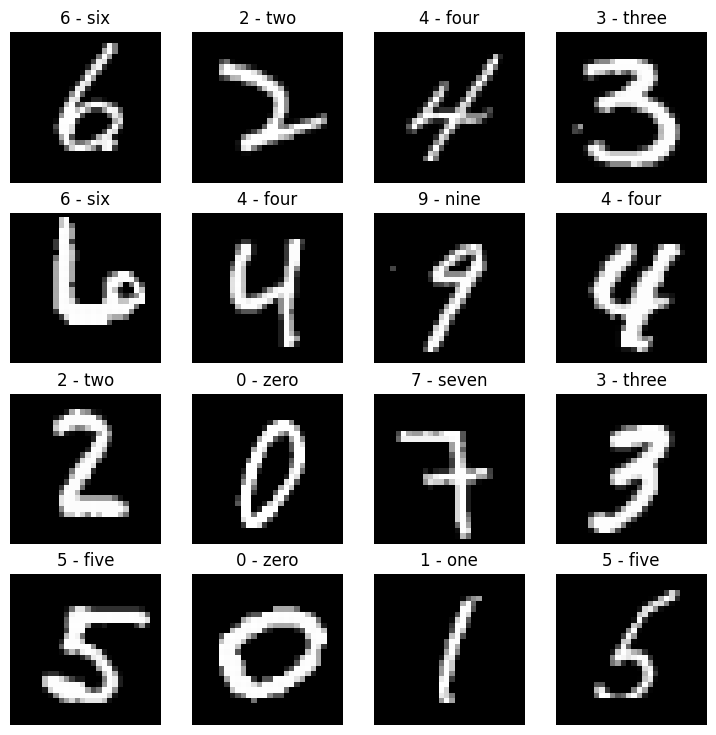

In [5]:
# Plot example images using a helper function
from matplotlib import pyplot as plt
from helper_functions import plot_example

plot_example(train_data=train_data, class_names=class_names)

## 4. Prepare DataLoaders

We use DataLoader to efficiently load data in batches during training and testing. This helps with memory management and speeds up training.

In [6]:
# Step 4: Create DataLoaders for batching
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader = DataLoader(train_data,
                            batch_size = BATCH_SIZE,
                            shuffle = True,
)
test_dataloader = DataLoader(test_data,
                            batch_size = BATCH_SIZE,
                            shuffle = False,
)

# Print DataLoader details
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(60000/32)
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")
print(10000/32) # gets rounded up, and the last batch has less than 32 items in it

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000001C83531EF80>, <torch.utils.data.dataloader.DataLoader object at 0x000001C86A133DF0>)
Length of train dataloader: 1875 batches of 32
1875.0
Length of test dataloader: 313 batches of 32
312.5


## 5. Define the CNN Model

We define a Convolutional Neural Network (CNN) using PyTorch's `nn.Module`. The model consists of two convolutional blocks followed by a fully connected layer.

In [7]:
# Step 5: Define the CNN model for MNIST classification
from torch import nn

class MNIST_model (nn.Module):
    def __init__(self, 
                input_shape:int,
                hidden_units:int,
                output_shape:int):
        super().__init__()
        
        # First convolutional block
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                    out_channels= hidden_units,
                    kernel_size= 3),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Second convolutional block
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                    out_channels= hidden_units,
                    kernel_size= 3),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Calculate the flattened feature size after conv blocks
        with torch.no_grad():
            dummy_input = torch.zeros(1, input_shape, 28, 28)
            x = self.block_1(dummy_input)
            x = self.block_2(x)
            num_features = x.shape[1] * x.shape[2] * x.shape[3]
            
        # Classifier (fully connected layer)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features= num_features,
                out_features= output_shape
            )
        )
        
    def forward (self, x:torch.Tensor):
        # Forward pass through conv blocks and classifier
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        
        return x
    

# Instantiate the model
number_model = MNIST_model(input_shape=1,
                    hidden_units=32,
                    output_shape=len(class_names))

number_model

MNIST_model(
  (block_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=512, out_features=10, bias=True)
  )
)

## 6. Set Up Loss, Optimizer, and Metrics

We use CrossEntropyLoss for multi-class classification, SGD optimizer, and accuracy as the evaluation metric.

In [8]:
# Step 6: Set up loss function, optimizer, and accuracy metric
from torchmetrics import Accuracy

acc_metric = Accuracy(task="multiclass", num_classes=len(class_names))
loss_fn = nn.CrossEntropyLoss()
optm = torch.optim.SGD(params= number_model.parameters(),
                    lr = 0.1)

## 7. Train the Model

We train the model for a specified number of epochs using helper functions for training and testing.

In [9]:
# Step 7: Train the model using helper functions
from helper_functions import train_and_test_model

train_and_test_model ( epochs = 5,
                        model= number_model,
                        loss_fn = loss_fn,
                        acc_fn = acc_metric,
                        optim = optm,
                        train_dataloader = train_dataloader,
                        test_dataloader = test_dataloader)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
-----------------------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


Train loss: 0.22019 | Train accuracy: 92.97%


 20%|██        | 1/5 [01:02<04:08, 62.05s/it]

Test loss: 0.05283 | Test accuracy: 98.26%


Epoch: 2
-----------------------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


Train loss: 0.06173 | Train accuracy: 98.11%


 40%|████      | 2/5 [01:44<02:31, 50.64s/it]

Test loss: 0.04087 | Test accuracy: 98.60%


Epoch: 3
-----------------------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


Train loss: 0.04602 | Train accuracy: 98.55%


 60%|██████    | 3/5 [02:18<01:25, 42.94s/it]

Test loss: 0.03867 | Test accuracy: 98.73%


Epoch: 4
-----------------------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


Train loss: 0.03761 | Train accuracy: 98.82%


 80%|████████  | 4/5 [02:50<00:38, 38.77s/it]

Test loss: 0.03553 | Test accuracy: 98.82%


Epoch: 5
-----------------------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


Train loss: 0.03106 | Train accuracy: 99.01%


100%|██████████| 5/5 [03:23<00:00, 40.64s/it]

Test loss: 0.03431 | Test accuracy: 98.86%


Time taken = 3 minutes and 23.21 seconds


## 8. Evaluate Model Performance

After training, we evaluate the model's performance on the test set using a helper function.

In [10]:
# Step 8: Evaluate the trained model on the test set
from helper_functions import eval_model

number_model_results = eval_model(model=number_model, 
                            data_loader=test_dataloader,
                            loss_fn=loss_fn, 
                            accuracy_fn=acc_metric
)
number_model_results

{'model_name': 'MNIST_model',
 'model_loss': 0.03430958464741707,
 'model_acc': 98.86000156402588}

## 9. Make Predictions and Visualize Results

We randomly select 16 test samples, make predictions, and visualize the results to see how well the model performs on unseen data.

In [11]:
# Step 9: Select random test samples and view their shapes and labels
import random
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=16): # k=16 to get 16 random samples
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (5 - five)


In [12]:
# Make predictions on test samples using the trained model
from helper_functions import make_predictions

# Make predictions on test samples with model 2
pred_probs= make_predictions(model=number_model, 
                            data=test_samples)

# Get predicted classes by taking the argmax
pred_classes = pred_probs.argmax(dim=1)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[1.4433e-08, 1.8091e-11, 5.5734e-12, 4.6154e-06, 1.2282e-10, 9.9997e-01,
         7.3405e-09, 3.8424e-13, 3.2618e-06, 1.9003e-05],
        [3.5723e-09, 1.7135e-12, 4.1328e-11, 1.4787e-04, 4.0344e-10, 9.9980e-01,
         3.1979e-08, 1.2674e-11, 2.3272e-06, 5.1500e-05]])

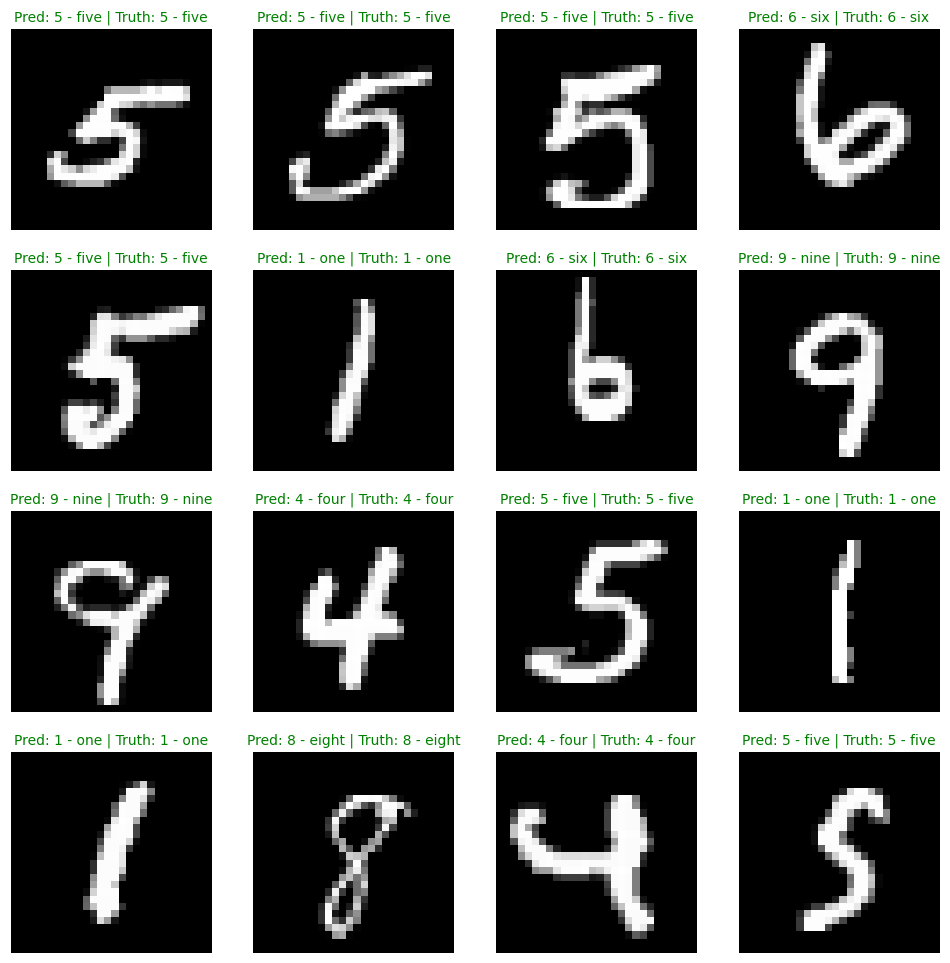

In [13]:
# Visualize predictions vs. true labels for the test samples
from helper_functions import test_model_plot

test_model_plot(test_samples= test_samples, 
                class_names=class_names, 
                pred_classes=pred_classes,
                test_labels=test_labels)

## 10. Plot Confusion Matrix

Finally, we plot a confusion matrix to visualize the model's performance across all classes. This helps identify which digits are most often confused by the model.

Making predictions: 100%|██████████| 313/313 [00:03<00:00, 101.47it/s]


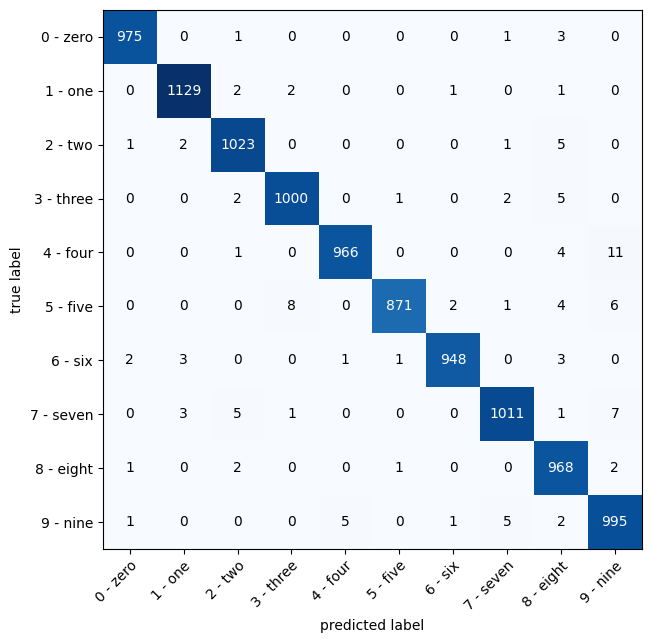

In [14]:
# Step 10: Plot confusion matrix for the test set predictions
from helper_functions import plot_conffusion_matrix

plot_conffusion_matrix(model=number_model, 
                    dataloader=test_dataloader,
                    class_names=class_names,
                    test_data=test_data)

## 11. Save the Trained Model

After evaluating the model, we save the trained model's state dictionary to disk using `torch.save`. This allows us to reload the model later for inference or further training.

In [15]:
# Step 11: Save the trained model to a file
import torch

MODEL_PATH = "MNIST_Model.pth"
torch.save(
    obj= number_model.state_dict(), 
    f= MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Model saved to MNIST_Model.pth


## 12. Train with Custom Datasets

In this section, we train the model with a custom MNIST dataset downloaded from KaggleHub. The dataset is in the form of numpy arrays (.npy files).

### Download and Load Custom MNIST Numpy Dataset

This section downloads the custom MNIST dataset from KaggleHub and loads the `.npy` files for images and labels.

In [16]:
# Download the dataset using kagglehub and print the path
import kagglehub

# Download latest version of the dataset from KaggleHub
path = kagglehub.dataset_download("hichamachahboun/mnist-handwritten-digits")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\User\.cache\kagglehub\datasets\hichamachahboun\mnist-handwritten-digits\versions\2


### Load Numpy Arrays

Load the train, validation, and test images and labels from the downloaded `.npy` files.

In [17]:
import numpy as np
import os

# Set the base path to the downloaded dataset files
BASE_PATH = r"C:\Users\User\.cache\kagglehub\datasets\hichamachahboun\mnist-handwritten-digits\versions\2"

# Load the .npy files for images and labels
train_val_images = np.load(os.path.join(BASE_PATH, "train_images.npy"))
train_val_labels = np.load(os.path.join(BASE_PATH, "train_labels.npy"))
test_images = np.load(os.path.join(BASE_PATH, "test_images.npy"))
test_labels = np.load(os.path.join(BASE_PATH, "test_labels.npy"))

### Prepare Torch Tensors and Split Train/Validation

Convert the numpy arrays to torch tensors, normalize pixel values to [0, 1], and split into train and validation sets.

In [18]:
# Normalize pixel values to [0, 1] and convert to torch tensors
train_val_images = torch.from_numpy(train_val_images).float().div(255).unsqueeze(1)  # [N, 1, 28, 28]
train_val_labels = torch.from_numpy(train_val_labels).long()

test_images = torch.from_numpy(test_images).float().div(255).unsqueeze(1)
test_labels = torch.from_numpy(test_labels).long()


# Split train/val (80% train, 20% val)
split_idx = int(0.8 * len(train_val_images))
train_images = train_val_images[:split_idx]
train_labels = train_val_labels[:split_idx]

val_images = train_val_images[split_idx:]
val_labels = train_val_labels[split_idx:]

print(train_val_images.shape)  # should be [60000, 1, 28, 28]
print(train_val_images.dtype)  # should be torch.float32


torch.Size([60000, 1, 28, 28])
torch.float32


### Create TensorDatasets

Wrap the train, validation, and test tensors in `TensorDataset` objects for use with PyTorch DataLoader.

In [19]:
from torch.utils.data import TensorDataset

# Create TensorDataset objects for train, validation, and test sets
train_dataset = TensorDataset(train_images, train_labels)
val_dataset = TensorDataset(val_images, val_labels)
test_dataset = TensorDataset(test_images, test_labels)

print(train_dataset, test_dataset)

<torch.utils.data.dataset.TensorDataset object at 0x000001C8151B58A0> <torch.utils.data.dataset.TensorDataset object at 0x000001C818ACAB60>


### Create DataLoaders and Inspect a Batch

Create DataLoaders for the train and test sets, and inspect the shape of a batch.

In [20]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Dataloaders for the custom MNIST dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(train_loader, test_loader)

# Show a sample image and label from the train set
img, label = train_dataset[0]
print(f"img = {img}")
print(f"label = {label}")

# Inspect the shape of a batch
for batch in train_loader:
    x, y = batch
    print(x.shape)
    break

<torch.utils.data.dataloader.DataLoader object at 0x000001C81845DA50> <torch.utils.data.dataloader.DataLoader object at 0x000001C818AC8430>
img = tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0

### Visualize Example Images from the Custom Dataset

Use the helper function to plot a grid of example images from the custom dataset.

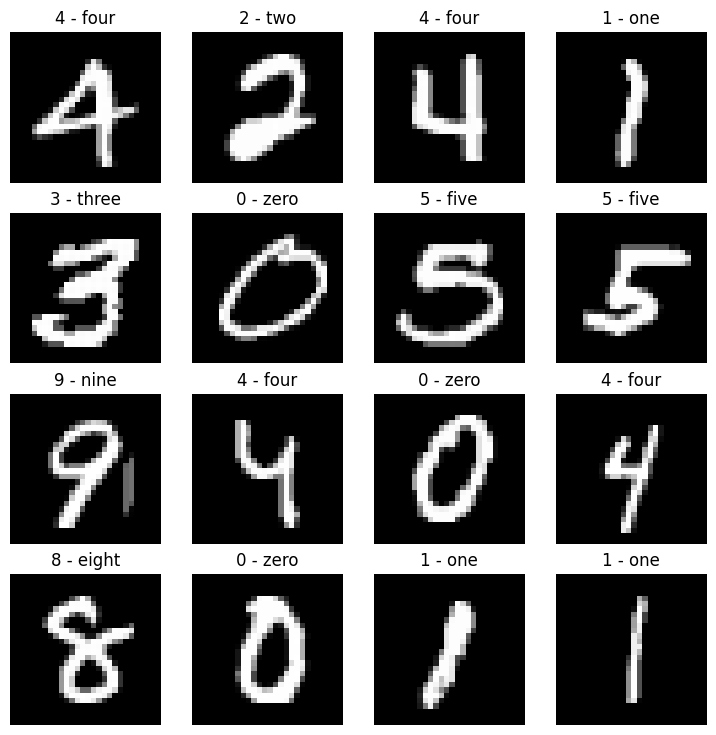

In [21]:
# Plot example images using a helper function
from matplotlib import pyplot as plt
from helper_functions import plot_example

plot_example(train_data=train_dataset, class_names=class_names)

### Train the Model on the Custom Dataset

Train the model using the custom dataset DataLoaders.

In [22]:
from helper_functions import train_and_test_model

# Train the model using the custom dataset
train_and_test_model ( epochs = 5,
                        model= number_model,
                        loss_fn = loss_fn,
                        acc_fn = acc_metric,
                        optim = optm,
                        train_dataloader = train_loader,
                        test_dataloader = test_loader)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
-----------------------------
Looked at 0/48000 samples
Looked at 12800/48000 samples
Looked at 25600/48000 samples
Looked at 38400/48000 samples


Train loss: 0.02748 | Train accuracy: 99.14%


 20%|██        | 1/5 [00:31<02:07, 31.93s/it]

Test loss: 0.03069 | Test accuracy: 99.03%


Epoch: 2
-----------------------------
Looked at 0/48000 samples
Looked at 12800/48000 samples
Looked at 25600/48000 samples
Looked at 38400/48000 samples


Train loss: 0.02261 | Train accuracy: 99.26%


 40%|████      | 2/5 [00:56<01:23, 27.79s/it]

Test loss: 0.02944 | Test accuracy: 99.13%


Epoch: 3
-----------------------------
Looked at 0/48000 samples
Looked at 12800/48000 samples
Looked at 25600/48000 samples
Looked at 38400/48000 samples


Train loss: 0.02045 | Train accuracy: 99.35%


 60%|██████    | 3/5 [01:23<00:54, 27.16s/it]

Test loss: 0.03061 | Test accuracy: 99.11%


Epoch: 4
-----------------------------
Looked at 0/48000 samples
Looked at 12800/48000 samples
Looked at 25600/48000 samples
Looked at 38400/48000 samples


Train loss: 0.01757 | Train accuracy: 99.46%


 80%|████████  | 4/5 [01:47<00:26, 26.20s/it]

Test loss: 0.03340 | Test accuracy: 98.91%


Epoch: 5
-----------------------------
Looked at 0/48000 samples
Looked at 12800/48000 samples
Looked at 25600/48000 samples
Looked at 38400/48000 samples


Train loss: 0.01693 | Train accuracy: 99.40%


100%|██████████| 5/5 [02:09<00:00, 25.95s/it]

Test loss: 0.03145 | Test accuracy: 99.08%


Time taken = 2 minutes and 9.73 seconds


### Save the Trained Model

Save the trained model's state dictionary to disk.

In [23]:
import torch

# Save the trained model to a file
MODEL_PATH = "MNIST_Model.pth"
torch.save(
    obj= number_model.state_dict(), 
    f= MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Model saved to MNIST_Model.pth


### Plot Confusion Matrix for TensorDataset

Use the helper function to plot a confusion matrix for predictions on a TensorDataset (e.g., from torch TensorDataset).

In [24]:
def plot_confusion_matrix_tensor_dataset(model, dataloader, class_names, test_dataset):
    """
    Plots a confusion matrix for predictions of a model on a TensorDataset (e.g., from torch TensorDataset).

    Args:
        model (nn.Module): Trained PyTorch model to evaluate.
        dataloader (DataLoader): DataLoader for the test dataset.
        class_names (list): List of class names for the dataset.
        test_dataset (TensorDataset): The original test dataset (used for true labels).

    Returns:
        None. Displays the confusion matrix plot.
    """
    from torchmetrics import ConfusionMatrix
    from mlxtend.plotting import plot_confusion_matrix
    import torch

    # 1. Make predictions with trained model
    y_preds = []
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(dataloader, desc="Making predictions"):
            y_logits = model(X)
            y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
            y_preds.append(y_pred)
        y_pred_tensor = torch.cat(y_preds)

    # 2. Get all true labels from the TensorDataset
    # test_dataset.tensors[1] is the label tensor
    y_true_tensor = test_dataset.tensors[1]

    # 3. Setup confusion matrix instance and compare predictions to targets
    con_mat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
    con_mat_tensor = con_mat(preds=y_pred_tensor, target=y_true_tensor)

    # 4. Plot the confusion matrix
    fig, ax = plot_confusion_matrix(
        conf_mat=con_mat_tensor.numpy(),
        class_names=class_names,
        figsize=(10, 7)
    )

Making predictions: 100%|██████████| 313/313 [00:01<00:00, 193.62it/s]


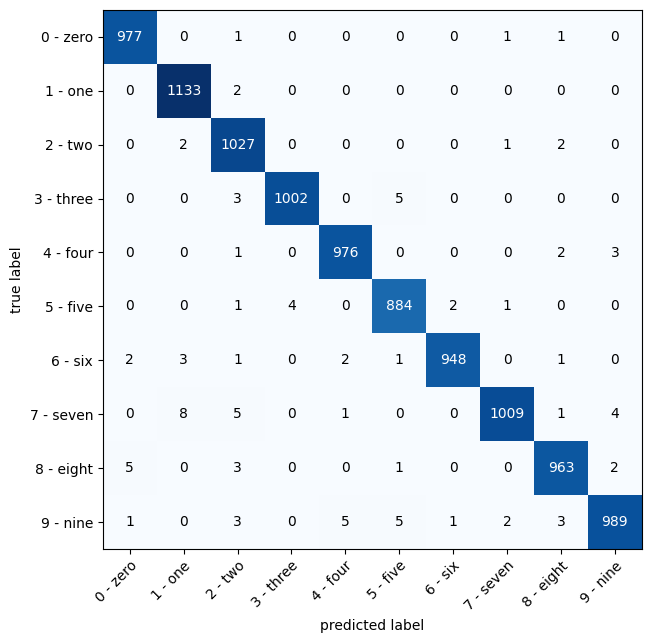

In [26]:
from tqdm.auto import tqdm
plot_confusion_matrix_tensor_dataset(model=number_model, 
                    dataloader=test_loader,
                    class_names=class_names,
                    test_dataset=test_dataset)

### (Optional) Load and Train on Japanese Handwritten Digits Dataset

This section demonstrates how to load and train on another custom dataset (Japanese Handwritten Digits) using the same workflow.

In [27]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anwarzalek/japanese-handwritten-digits")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\User\.cache\kagglehub\datasets\anwarzalek\japanese-handwritten-digits\versions\1


In [28]:
# Set the base path to the downloaded dataset files
BASE_PATH = r"C:\Users\User\.cache\kagglehub\datasets\anwarzalek\japanese-handwritten-digits\versions\1\Japanese Handwritten Digits"

from torch.utils.data import random_split, DataLoader

# Define transforms (e.g., resize, grayscale, tensor conversion, normalize)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # In case images are RGB
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load dataset using ImageFolder
full_dataset = datasets.ImageFolder(root=BASE_PATH, transform=transform)

# Split dataset into train and test
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print to verify
print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Classes: {full_dataset.classes}")


Train samples: 10800
Test samples: 2700
Classes: ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09']


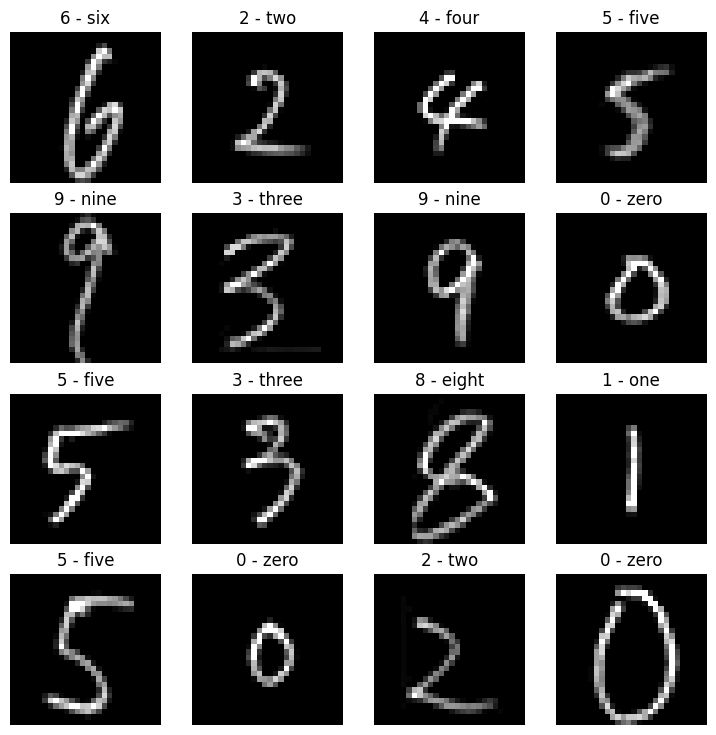

In [29]:
plot_example(train_data=train_dataset, class_names=class_names)

In [30]:
# Train the model using the Japanese Handwritten Digits dataset
train_and_test_model ( epochs = 5,
                        model= number_model,
                        loss_fn = loss_fn,
                        acc_fn = acc_metric,
                        optim = optm,
                        train_dataloader = train_loader,
                        test_dataloader = test_loader)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
-----------------------------
Looked at 0/10800 samples


Train loss: 0.24346 | Train accuracy: 93.44%


 20%|██        | 1/5 [00:17<01:11, 17.90s/it]

Test loss: 0.20463 | Test accuracy: 94.70%


Epoch: 2
-----------------------------
Looked at 0/10800 samples


Train loss: 0.14374 | Train accuracy: 96.05%


 40%|████      | 2/5 [00:30<00:43, 14.52s/it]

Test loss: 0.19721 | Test accuracy: 94.52%


Epoch: 3
-----------------------------
Looked at 0/10800 samples


Train loss: 0.11353 | Train accuracy: 97.06%


 60%|██████    | 3/5 [00:42<00:26, 13.48s/it]

Test loss: 0.18740 | Test accuracy: 95.04%


Epoch: 4
-----------------------------
Looked at 0/10800 samples


Train loss: 0.09792 | Train accuracy: 97.33%


 80%|████████  | 4/5 [00:53<00:12, 12.50s/it]

Test loss: 0.16087 | Test accuracy: 95.89%


Epoch: 5
-----------------------------
Looked at 0/10800 samples


Train loss: 0.08156 | Train accuracy: 98.03%


100%|██████████| 5/5 [01:04<00:00, 12.82s/it]

Test loss: 0.17288 | Test accuracy: 96.15%


Time taken = 1 minutes and 4.12 seconds


In [31]:
# Save the trained model after training on the Japanese dataset
import torch

MODEL_PATH = "MNIST_Model.pth"
torch.save(
    obj= number_model.state_dict(), 
    f= MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Model saved to MNIST_Model.pth


In [33]:
# Plot confusion matrix for the Japanese Handwritten Digits dataset
plot_confusion_matrix_tensor_dataset(model=number_model, 
                    dataloader=test_loader,
                    class_names=class_names,
                    test_dataset=test_dataset)

Making predictions: 100%|██████████| 85/85 [00:01<00:00, 44.64it/s]


AttributeError: 'Subset' object has no attribute 'tensors'

---

## Summary

This notebook demonstrated a complete workflow for digit classification using PyTorch, including data loading, visualization, model definition, training, evaluation, and working with custom datasets. You can adapt this workflow to other image classification tasks by changing the dataset and adjusting the model architecture as needed.